In [1]:
import os
import gc
import sys 
import torch
import pickle
import importlib
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import dataloader_private
from dataloader_private import RNA_Sub_Dataset, LenMatchBatchSampler, DeviceDataLoader

import model
from model import RNA_Model

import metrics
from metrics import MAE, loss

from fastai.vision.data import  DataLoaders
from fastai.vision.all import Learner, GradientClip

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='2'
fname = 'example0'
PATH = '/scratch/lemercier/WIP_data/'
OUT = './'
bs = 128
num_workers = 2
nfolds = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
seq_pred = pd.read_csv(os.path.join(PATH,'test_sequences.csv'))

In [23]:
private = seq_pred.query('future==1') 

**(If generalization test only, select the relevant sequences)**

In [ ]:
id1=269545321
id2=269724007
private = private.query('id_min>={0} and id_min<={1}'.format(id1,id2))

In [ ]:
# prepare data
ds_sub = RNA_Sub_Dataset(private)
ds_len = RNA_Sub_Dataset(private, mask_only=True)
sampler = torch.utils.data.SequentialSampler(ds_len)
len_sampler = LenMatchBatchSampler(sampler, batch_size=bs,
            drop_last=False)
dl_sub = DeviceDataLoader(torch.utils.data.DataLoader(ds_sub, 
           batch_sampler=len_sampler, num_workers=num_workers), device)
gc.collect()

# load model
model = RNA_Model()
model.load_state_dict(torch.load('/home/lemercier/Desktop/WIP/modelAF_v2_72.pth'))

model.eval()

model = model.to(device) 

res = []
for batch in tqdm(dl_sub):   
  
    with torch.no_grad():

        batch[0]['bppm'] = batch[0]['bppm'].float()

        pred = model.forward(batch[0])

        pred = (None,pred)
        b = pred[1].shape[0]
        reac = pred[1][batch[1]['mask'][:,:pred[1].shape[1]]].reshape(b,-1,2).detach().cpu().numpy()


        # fill results
        id_mins = batch[0]['id_min'].detach().cpu().numpy()
        id_maxs = batch[0]['id_max'].detach().cpu().numpy()

        for i in range(b):
            id_ = np.arange(id_mins[i], id_maxs[i]+1)
            data = np.stack([id_, reac[i,:,1], reac[i,:,0]]).T
            res.append(pd.DataFrame(data, columns=['id','reactivity_DMS_MaP','reactivity_2A3_MaP', 'bppm'])                    

In [29]:
res_ = pd.concat(res)
df = res_.astype({'id': 'int'})

In [30]:
df = df.sort_values(by='id')

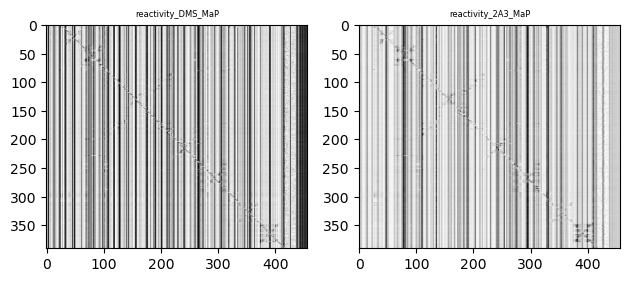

In [256]:
font_size=6
reshape1=391
reshape2=457
#get predictions
pred_DMS=df['reactivity_DMS_MaP'].to_numpy().reshape(reshape1,reshape2)
pred_2A3=df['reactivity_2A3_MaP'].to_numpy().reshape(reshape1,reshape2).copy()
# pred_2A3[55][353]=50
#plot mutate and map
fig = plt.figure()
plt.subplot(121)
plt.title(f'reactivity_DMS_MaP', fontsize=font_size)
plt.imshow(pred_DMS,vmin=0,vmax=1, cmap='gray_r')
plt.subplot(122)
plt.title(f'reactivity_2A3_MaP', fontsize=font_size)
plt.imshow(pred_2A3,vmin=0,vmax=1, cmap='gray_r')
plt.tight_layout()
plt.show()